In [1]:
%cd /Users/genevieveberent/Desktop/DS_Capstone

/Users/genevieveberent/Desktop/DS_Capstone


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import plotly.plotly as py
import plotly.offline as pyo
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
from plotly.tools import FigureFactory as FF

init_notebook_mode(connected=True)

In [3]:
## Import all the quarter 2 data
q2_2018 = pd.read_csv('Divvy_Trips_2018_Q2.csv')
q2_2017 = pd.read_csv('Divvy_Trips_2017_Q2.csv')
q2_2016_4 = pd.read_csv('Divvy_Trips_2016_04.csv')
q2_2016_5 = pd.read_csv('Divvy_Trips_2016_05.csv')
q2_2016_6 = pd.read_csv('Divvy_Trips_2016_06.csv')
q2_2015 = pd.read_csv('Divvy_Trips_2015-Q2.csv')

In [4]:
## Concat the 2016 data into one df
q2_2016 = pd.concat([q2_2016_4, q2_2016_5, q2_2016_6])

In [5]:
## Rename columns to match others
q2_2015.rename(columns={'starttime':'start_time', 'stoptime':'end_time'}, inplace=True)
q2_2016.rename(columns={'starttime':'start_time', 'stoptime':'end_time'}, inplace=True)

In [6]:
## Concatenate all 4 years of data
q2 = pd.concat([q2_2015, q2_2016, q2_2017, q2_2018])

In [7]:
## Find the number of check-outs per station
station_counts_from = pd.DataFrame(q2['from_station_id'].value_counts())

In [8]:
## Top 5 Stations with the most check-outs
station_counts_from.head()

from_station_id
35            100085
76             63293
177            53591
268            53260
91             51871

In [9]:
## Find the number of check-ins per station
station_counts_to= pd.DataFrame(q2['to_station_id'].value_counts())

In [10]:
## Top 5 stations with the most check-ins
station_counts_to.head()

to_station_id
35          113731
268          61225
76           58945
177          58246
90           49645

In [11]:
## Create a DataFrame with the check-outs and check-ins
## Create a columns that sums check-outs and check-ins
station_counts = pd.concat([station_counts_from, station_counts_to], axis=1)
station_counts.rename(columns={'from_station_id':'checkouts', 'to_station_id':'checkins'}, inplace=True)
station_counts['total'] = station_counts['checkouts'] + station_counts['checkins']

In [12]:
station_counts.head()

checkouts  checkins  total
2      19636     18114  37750
3      32516     30400  62916
4      23385     23742  47127
5       9818     10125  19943
6      24221     21159  45380

In [13]:
## After some research, we will use the top 26 stations
## The top 26 stations have a total > 50,000
station_counts_26 = station_counts.sort_values('total', ascending=False).head(26)
stations = list(station_counts_26.index)

In [14]:
## Extract just trips that involve the 26 stations in the model
q2_stations = q2[(q2['from_station_id'].isin(stations)) | (q2['to_station_id'].isin(stations))]

In [15]:
q2_stations.head(3)

trip_id       start_time       end_time  bikeid tripduration  \
5  5943494  6/30/2015 23:57  7/1/2015 0:11    4293          865   
6  5943493  6/30/2015 23:57  7/1/2015 0:35     521         2285   
7  5943492  6/30/2015 23:57  7/1/2015 0:16     581         1156   

   from_station_id             from_station_name  to_station_id  \
5               43  Michigan Ave & Washington St             59   
6               43  Michigan Ave & Washington St             59   
7               43  Michigan Ave & Washington St             57   

             to_station_name    usertype  gender  birthyear  
5  Wabash Ave & Roosevelt Rd  Subscriber  Female     1993.0  
6  Wabash Ave & Roosevelt Rd  Subscriber    Male     1993.0  
7  Clinton St & Roosevelt Rd  Subscriber    Male     1994.0

In [16]:
## Explore the number of trips overall and in our model

total_trip_count = q2['trip_id'].count()
top_26_count = q2_stations['trip_id'].count()
percent = round(top_26_count/total_trip_count, 3) * 100

print("Of the {} total trips, {} involve one of our 26 stations. That's {}%".format(total_trip_count, 
                                                                                    top_26_count,
                                                                                    percent))

Of the 4146212 total trips, 1638465 involve one of our 26 stations. That's 39.5%


In [17]:
## Convert the 'start_time' column to a datetime object
q2_stations['start_time'] = pd.to_datetime(q2_stations['start_time'])

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [18]:
## Begin creating the DataFrame for the model to be used
q2_model = q2_stations[['start_time', 'end_time', 'from_station_id', 'to_station_id']]

In [19]:
q2_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638465 entries, 5 to 1059680
Data columns (total 4 columns):
start_time         1638465 non-null datetime64[ns]
end_time           1638465 non-null object
from_station_id    1638465 non-null int64
to_station_id      1638465 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 62.5+ MB


In [20]:
q2_model.head(3)

start_time       end_time  from_station_id  to_station_id
5 2015-06-30 23:57:00  7/1/2015 0:11               43             59
6 2015-06-30 23:57:00  7/1/2015 0:35               43             59
7 2015-06-30 23:57:00  7/1/2015 0:16               43             57

In [21]:
q2_model['start_time'] = pd.to_datetime(q2_model['start_time'])

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [22]:
## Make the 'start_time' the index
q2_model.index = q2_model['start_time']
q2_model.drop('start_time', axis=1, inplace=True)

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [23]:
## Create a column of the day name (ie. Sunday, Monday, Tuesday)
q2_model['day'] = q2_model.index.day_name()

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [24]:
## Add the year (2015-2018)
## Add the hour of day (0-23)

q2_model['year'] = q2_model.index.map(lambda x:str(x)[:4])
q2_model['hour'] = q2_model.index.map(lambda x:str(x)[11:13])

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [25]:
q2_model.head(2)

end_time  from_station_id  to_station_id      day  \
start_time                                                                    
2015-06-30 23:57:00  7/1/2015 0:11               43             59  Tuesday   
2015-06-30 23:57:00  7/1/2015 0:35               43             59  Tuesday   

                     year hour  
start_time                      
2015-06-30 23:57:00  2015   23  
2015-06-30 23:57:00  2015   23

# Add in weather data

In [26]:
## Import the bulk weather data downloaded from darksky.net
weather = pd.read_csv('divvy_weather.csv')

In [27]:
weather.head(2)

Unnamed: 0               dt_iso  humidity  wind_speed  rain_1h  rain_today  \
0           0  2014-01-01 00:00:00        85           0      3.0         NaN   
1           1  2014-01-01 01:00:00        89           1      3.0         NaN   

   snow_1h  snow_today     temp_f  
0      NaN         NaN  11.894028  
1      NaN         NaN  12.127972

In [28]:
## Drop unnecessary columns
weather.drop(['Unnamed: 0', 'rain_today', 'snow_today'], axis=1, inplace=True)

In [29]:
## Create columns in both DataFrames to merge on
## This is the date down the hour

q2_model['merge_col'] = q2_model.index.map(lambda x:str(x)[:13])
weather['merge_col'] = weather['dt_iso'].map(lambda x:str(x)[:13])

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [30]:
## Rearrange columns to set the new 'merge_cols' as the index for each df

q2_model['start_time'] = q2_model.index 
q2_model.index = q2_model['merge_col']
weather.index = weather['merge_col']

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [31]:
## Add the weather data to the station data
q2_model = q2_model.merge(weather)

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

'merge_col' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



In [32]:
q2_model.head(2)

end_time  from_station_id  to_station_id      day  year hour  \
0  6/30/2015 23:14               35             52  Tuesday  2015   22   
1  6/30/2015 23:09              100            289  Tuesday  2015   22   

       merge_col          start_time               dt_iso  humidity  \
0  2015-06-30 22 2015-06-30 22:59:00  2015-06-30 22:00:00        64   
1  2015-06-30 22 2015-06-30 22:59:00  2015-06-30 22:00:00        64   

   wind_speed  rain_1h  snow_1h  temp_f  
0           7      NaN      NaN  71.474  
1           7      NaN      NaN  71.474

In [33]:
## Drop unnecessary columns
q2_model.drop(['merge_col', 'dt_iso', 'humidity'], axis=1, inplace=True)

In [34]:
q2_model.head(2)

end_time  from_station_id  to_station_id      day  year hour  \
0  6/30/2015 23:14               35             52  Tuesday  2015   22   
1  6/30/2015 23:09              100            289  Tuesday  2015   22   

           start_time  wind_speed  rain_1h  snow_1h  temp_f  
0 2015-06-30 22:59:00           7      NaN      NaN  71.474  
1 2015-06-30 22:59:00           7      NaN      NaN  71.474

In [35]:
## Make 'start_time' index
## Rename rain and snow columns

q2_model.index = q2_model['start_time']
q2_model.rename(columns={'rain_1h':'rain', 'snow_1hr':'snow', 'temp_f':'temp'}, inplace=True)

In [36]:
q2_model.head(2)

end_time  from_station_id  to_station_id      day  \
start_time                                                                      
2015-06-30 22:59:00  6/30/2015 23:14               35             52  Tuesday   
2015-06-30 22:59:00  6/30/2015 23:09              100            289  Tuesday   

                     year hour          start_time  wind_speed  rain  snow_1h  \
start_time                                                                      
2015-06-30 22:59:00  2015   22 2015-06-30 22:59:00           7   NaN      NaN   
2015-06-30 22:59:00  2015   22 2015-06-30 22:59:00           7   NaN      NaN   

                       temp  
start_time                   
2015-06-30 22:59:00  71.474  
2015-06-30 22:59:00  71.474

In [37]:
## Sum the number of check-outs by station by day by hour

q2_model_from_counts = pd.DataFrame(q2_model.groupby(['from_station_id', 'day', 'hour'])['year'].count())

In [38]:
q2_model_from_counts.head()

year
from_station_id day    hour      
2               Friday 00       1
                       05       3
                       06       4
                       07      16
                       08      27

In [39]:
## Reset the index to fill in each row with the station name, day, hour and check-out count
q2_model_from_counts.reset_index()

from_station_id        day hour  year
0                    2     Friday   00     1
1                    2     Friday   05     3
2                    2     Friday   06     4
3                    2     Friday   07    16
4                    2     Friday   08    27
5                    2     Friday   09    31
6                    2     Friday   10    59
7                    2     Friday   11    55
8                    2     Friday   12    56
9                    2     Friday   13    71
10                   2     Friday   14    76
11                   2     Friday   15    97
12                   2     Friday   16    88
13                   2     Friday   17   101
14                   2     Friday   18    54
15                   2     Friday   19    38
16                   2     Friday   20    34
17                   2     Friday   21    19
18                   2     Friday   22    12
19                   2     Friday   23    10
20                   2     Monday   00     4
21                   2     Monday   02     2
22                   2     Monday   06     5
23                   2     Monday   07    23
24                   2     Monday   08    28
25                   2     Monday   09    39
26                   2     Monday   10    64
27                   2     Monday   11    66
28                   2     Monday   12    95
29                   2     Monday   13    81
...                ...        ...  ...   ...
38449              627    Tuesday   10     1
38450              627    Tuesday   11     3
38451              627    Tuesday   12     2
38452              627    Tuesday   13     2
38453              627    Tuesday   14     3
38454              627    Tuesday   15     7
38455              627    Tuesday   16     6
38456              627    Tuesday   17     8
38457              627    Tuesday   18     9
38458              627    Tuesday   19     5
38459              627    Tuesday   20     3
38460              627    Tuesday   21     1
38461              627  Wednesday   05     7
38462              627  Wednesday   06     7
38463              627  Wednesday   07     7
38464              627  Wednesday   08     4
38465              627  Wednesday   09     4
38466              627  Wednesday   10     2
38467              627  Wednesday   11     5
38468              627  Wednesday   12     4
38469              627  Wednesday   13     5
38470              627  Wednesday   14     5
38471              627  Wednesday   15     4
38472              627  Wednesday   16    13
38473              627  Wednesday   17    20
38474              627  Wednesday   18    17
38475              627  Wednesday   19     5
38476              627  Wednesday   20     6
38477              627  Wednesday   21     4
38478              627  Wednesday   22     4

[38479 rows x 4 columns]

# Preprocess to get Dataframe for Checkouts

In [40]:
## Only get the instances where the check-out station is one of the top 26

checkouts = q2_model[q2_model['from_station_id'].isin(stations)]

In [41]:
checkouts.rename(columns={'snow_1h':'snow'}, inplace=True)

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [42]:
checkouts.head(2)

end_time  from_station_id  to_station_id      day  \
start_time                                                                      
2015-06-30 22:59:00  6/30/2015 23:14               35             52  Tuesday   
2015-06-30 22:58:00  6/30/2015 23:14               35             52  Tuesday   

                     year hour          start_time  wind_speed  rain  snow  \
start_time                                                                   
2015-06-30 22:59:00  2015   22 2015-06-30 22:59:00           7   NaN   NaN   
2015-06-30 22:58:00  2015   22 2015-06-30 22:58:00           7   NaN   NaN   

                       temp  
start_time                   
2015-06-30 22:59:00  71.474  
2015-06-30 22:58:00  71.474

In [43]:
## Add the month of the ride as well (ie. April, May, June)
checkouts['month'] = checkouts.index.map(lambda x:str(x)[5:7])

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [44]:
## Create column down to the hour to be able to sum the check-outs by hour

checkouts['groupby_col'] = checkouts.index.map(lambda x:str(x)[:13])

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [45]:
checkouts.head(3)

end_time  from_station_id  to_station_id      day  \
start_time                                                                      
2015-06-30 22:59:00  6/30/2015 23:14               35             52  Tuesday   
2015-06-30 22:58:00  6/30/2015 23:14               35             52  Tuesday   
2015-06-30 22:58:00  6/30/2015 23:14               35             52  Tuesday   

                     year hour          start_time  wind_speed  rain  snow  \
start_time                                                                   
2015-06-30 22:59:00  2015   22 2015-06-30 22:59:00           7   NaN   NaN   
2015-06-30 22:58:00  2015   22 2015-06-30 22:58:00           7   NaN   NaN   
2015-06-30 22:58:00  2015   22 2015-06-30 22:58:00           7   NaN   NaN   

                       temp month    groupby_col  
start_time                                        
2015-06-30 22:59:00  71.474    06  2015-06-30 22  
2015-06-30 22:58:00  71.474    06  2015-06-30 22  
2015-06-30 22:58:00  71.474    06  2015-06-30 22

In [46]:
## Sum the number of check-outs by station and hour (using the groupby_col column)

checkouts_model = pd.DataFrame(checkouts.groupby(['from_station_id', 'groupby_col'])['hour'].count())

In [47]:
## Rename the 'hour' to 'checkout_count'
## Make the 'grouby_col' the index

checkouts_model.rename(columns={'hour':'checkout_count'}, inplace=True)
checkouts_model.reset_index(inplace=True)
checkouts_model.index = checkouts_model['groupby_col']

In [48]:
checkouts_model.head(2)

from_station_id    groupby_col  checkout_count
groupby_col                                                  
2015-06-12 01                3  2015-06-12 01               3
2015-06-12 23                3  2015-06-12 23               2

In [49]:
weather.head(2)

dt_iso  humidity  wind_speed  rain_1h  snow_1h  \
merge_col                                                                    
2014-01-01 00  2014-01-01 00:00:00        85           0      3.0      NaN   
2014-01-01 01  2014-01-01 01:00:00        89           1      3.0      NaN   

                  temp_f      merge_col  
merge_col                                
2014-01-01 00  11.894028  2014-01-01 00  
2014-01-01 01  12.127972  2014-01-01 01

In [50]:
## Add the weather data 

checkouts_model = checkouts_model.merge(weather, left_index=True, right_index=True)

In [51]:
checkouts_model.head(2)

from_station_id    groupby_col  checkout_count  \
2015-06-12 01                3  2015-06-12 01               3   
2015-06-12 23                3  2015-06-12 23               2   

                            dt_iso  humidity  wind_speed  rain_1h  snow_1h  \
2015-06-12 01  2015-06-12 01:00:00        89           2      NaN      NaN   
2015-06-12 23  2015-06-12 23:00:00       100           3      0.3      NaN   

                temp_f      merge_col  
2015-06-12 01  57.3548  2015-06-12 01  
2015-06-12 23  53.1374  2015-06-12 23

In [52]:
## Drop and rename the appropriate columns

checkouts_model.drop(['dt_iso', 'humidity', 'merge_col'], axis=1, inplace=True)
checkouts_model.rename(columns={'rain_1h':'rain', 'snow_1h':'snow', 'temp_f':'temp'}, inplace=True)

In [53]:
checkouts_model.head(3)

from_station_id    groupby_col  checkout_count  wind_speed  \
2015-06-12 01                3  2015-06-12 01               3           2   
2015-06-12 23                3  2015-06-12 23               2           3   
2015-06-12 23               26  2015-06-12 23               1           3   

               rain  snow     temp  
2015-06-12 01   NaN   NaN  57.3548  
2015-06-12 23   0.3   NaN  53.1374  
2015-06-12 23   0.3   NaN  53.1374

In [54]:
## Add the year, month and hour columns

checkouts_model['year'] = checkouts_model.index.map(lambda x:str(x)[:4])
checkouts_model['month'] = checkouts_model.index.map(lambda x:str(x)[5:7])
checkouts_model['hour'] = checkouts_model.index.map(lambda x:str(x)[11:13])

In [55]:
checkouts_model.head(3)

from_station_id    groupby_col  checkout_count  wind_speed  \
2015-06-12 01                3  2015-06-12 01               3           2   
2015-06-12 23                3  2015-06-12 23               2           3   
2015-06-12 23               26  2015-06-12 23               1           3   

               rain  snow     temp  year month hour  
2015-06-12 01   NaN   NaN  57.3548  2015    06   01  
2015-06-12 23   0.3   NaN  53.1374  2015    06   23  
2015-06-12 23   0.3   NaN  53.1374  2015    06   23

In [56]:
checkouts_model['groupby_col'] = pd.to_datetime(checkouts_model['groupby_col'])
checkouts_model.index = checkouts_model['groupby_col']

In [57]:
checkouts_model.head(3)

from_station_id         groupby_col  checkout_count  \
groupby_col                                                                
2015-06-12 01:00:00                3 2015-06-12 01:00:00               3   
2015-06-12 23:00:00                3 2015-06-12 23:00:00               2   
2015-06-12 23:00:00               26 2015-06-12 23:00:00               1   

                     wind_speed  rain  snow     temp  year month hour  
groupby_col                                                            
2015-06-12 01:00:00           2   NaN   NaN  57.3548  2015    06   01  
2015-06-12 23:00:00           3   0.3   NaN  53.1374  2015    06   23  
2015-06-12 23:00:00           3   0.3   NaN  53.1374  2015    06   23

In [58]:
## Add the day of week

checkouts_model['day'] = checkouts_model.index.day_name()

In [59]:
checkouts_model.head(3)

from_station_id         groupby_col  checkout_count  \
groupby_col                                                                
2015-06-12 01:00:00                3 2015-06-12 01:00:00               3   
2015-06-12 23:00:00                3 2015-06-12 23:00:00               2   
2015-06-12 23:00:00               26 2015-06-12 23:00:00               1   

                     wind_speed  rain  snow     temp  year month hour     day  
groupby_col                                                                    
2015-06-12 01:00:00           2   NaN   NaN  57.3548  2015    06   01  Friday  
2015-06-12 23:00:00           3   0.3   NaN  53.1374  2015    06   23  Friday  
2015-06-12 23:00:00           3   0.3   NaN  53.1374  2015    06   23  Friday

In [60]:
## Replace the 'NaN' with 0, meaning there was no rain/snow that hour

checkouts_model['rain'].fillna(0, inplace=True)
checkouts_model['snow'].fillna(0, inplace=True)

In [61]:
checkouts_model.drop('groupby_col', axis=1, inplace=True)

In [62]:
checkouts_model.head(3)

from_station_id  checkout_count  wind_speed  rain  snow  \
groupby_col                                                                    
2015-06-12 01:00:00                3               3           2   0.0   0.0   
2015-06-12 23:00:00                3               2           3   0.3   0.0   
2015-06-12 23:00:00               26               1           3   0.3   0.0   

                        temp  year month hour     day  
groupby_col                                            
2015-06-12 01:00:00  57.3548  2015    06   01  Friday  
2015-06-12 23:00:00  53.1374  2015    06   23  Friday  
2015-06-12 23:00:00  53.1374  2015    06   23  Friday

In [63]:
cols = checkouts_model.columns.tolist()

In [64]:
new_cols = ['checkout_count','from_station_id','year','month','hour','day','wind_speed','rain','snow','temp']

In [65]:
## Rearrange the order of the columns

checkouts_model = checkouts_model[new_cols]

In [66]:
checkouts_model.head(3)

checkout_count  from_station_id  year month hour     day  \
groupby_col                                                                     
2015-06-12 01:00:00               3                3  2015    06   01  Friday   
2015-06-12 23:00:00               2                3  2015    06   23  Friday   
2015-06-12 23:00:00               1               26  2015    06   23  Friday   

                     wind_speed  rain  snow     temp  
groupby_col                                           
2015-06-12 01:00:00           2   0.0   0.0  57.3548  
2015-06-12 23:00:00           3   0.3   0.0  53.1374  
2015-06-12 23:00:00           3   0.3   0.0  53.1374

## Model for predicting Checkouts at a given station

In [67]:
## Convert categorical columns into dummy columns

checkouts_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106773 entries, 2015-06-12 01:00:00 to 2018-06-30 23:00:00
Data columns (total 10 columns):
checkout_count     106773 non-null int64
from_station_id    106773 non-null int64
year               106773 non-null object
month              106773 non-null object
hour               106773 non-null object
day                106773 non-null object
wind_speed         106773 non-null int64
rain               106773 non-null float64
snow               106773 non-null float64
temp               106773 non-null float64
dtypes: float64(3), int64(3), object(4)
memory usage: 11.5+ MB


In [68]:
## Convert the 'from_station_id' from an int to str

checkouts_model['from_station_id'] = checkouts_model['from_station_id'].apply(str)

In [69]:
## 'from_station_id', 'year', 'month', 'day', 'hour' columns to be converted to dummies

checkouts = pd.get_dummies(data=checkouts_model, columns=['from_station_id', 'year', 'month', 'day', 'hour'])

In [70]:
## Convert the temperature from Farenheit to Celcius 

checkouts['temp'] = (checkouts['temp'] - 32) * 5/9

In [71]:
checkouts.head(1)

checkout_count  wind_speed  rain  snow    temp  \
groupby_col                                                           
2015-06-12 01:00:00               3           2   0.0   0.0  14.086   

                     from_station_id_110  from_station_id_133  \
groupby_col                                                     
2015-06-12 01:00:00                    0                    0   

                     from_station_id_174  from_station_id_176  \
groupby_col                                                     
2015-06-12 01:00:00                    0                    0   

                     from_station_id_177   ...     hour_14  hour_15  hour_16  \
groupby_col                                ...                                 
2015-06-12 01:00:00                    0   ...           0        0        0   

                     hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
groupby_col                                                                 
2015-06-12 01:00:00        0        0        0        0        0        0   

                     hour_23  
groupby_col                   
2015-06-12 01:00:00        0  

[1 rows x 69 columns]

In [72]:
checkouts.shape

(106773, 69)

## Analyze the target column

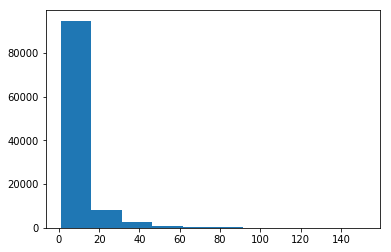

In [73]:
## Histogram to analyze the shape of the target column

plt.hist(checkouts['checkout_count'])
plt.show()

In [74]:
## Find the skew of the check-outs

checkouts['checkout_count'].skew()

3.6140153546984317

A skew of 0 is a normally distributed, a skew of 3.614 means the data is right skewed.  

In [75]:
## Check skew of multiple transformations

log_trans = np.log(checkouts['checkout_count']).skew()
sqrt_trans = (checkouts['checkout_count'] ** .5).skew()
cube_trans = (checkouts['checkout_count'] ** (1/3)).skew()

print('Log Transformation:', log_trans)
print('Square Root Transformation:', sqrt_trans)
print('Cube Root Transformation', cube_trans)

Log Transformation: 0.3323326430878915
Square Root Transformation: 1.624012757982214
Cube Root Transformation 1.1283451884542186


Our goal is to get the skew as close to 0 as possible, therefore the check-out column will be transformed using a log transformation.

In [76]:
## Transform the check-out values

checkouts['checkout_count(log)'] = np.log(checkouts['checkout_count'])

In [77]:
checkouts.head(3)

checkout_count  wind_speed  rain  snow    temp  \
groupby_col                                                           
2015-06-12 01:00:00               3           2   0.0   0.0  14.086   
2015-06-12 23:00:00               2           3   0.3   0.0  11.743   
2015-06-12 23:00:00               1           3   0.3   0.0  11.743   

                     from_station_id_110  from_station_id_133  \
groupby_col                                                     
2015-06-12 01:00:00                    0                    0   
2015-06-12 23:00:00                    0                    0   
2015-06-12 23:00:00                    0                    0   

                     from_station_id_174  from_station_id_176  \
groupby_col                                                     
2015-06-12 01:00:00                    0                    0   
2015-06-12 23:00:00                    0                    0   
2015-06-12 23:00:00                    0                    0   

                     from_station_id_177         ...           hour_15  \
groupby_col                                      ...                     
2015-06-12 01:00:00                    0         ...                 0   
2015-06-12 23:00:00                    0         ...                 0   
2015-06-12 23:00:00                    0         ...                 0   

                     hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
groupby_col                                                                 
2015-06-12 01:00:00        0        0        0        0        0        0   
2015-06-12 23:00:00        0        0        0        0        0        0   
2015-06-12 23:00:00        0        0        0        0        0        0   

                     hour_22  hour_23  checkout_count(log)  
groupby_col                                                 
2015-06-12 01:00:00        0        0             1.098612  
2015-06-12 23:00:00        0        1             0.693147  
2015-06-12 23:00:00        0        1             0.000000  

[3 rows x 70 columns]

# Finally making the model

## Linear Regression

In [78]:
## Split the the DataFrame into a training and testing sets
## The testing set will be the last two weeks of June

training = checkouts[:100831]
testing = checkouts[100831:]

In [79]:
## Splitting the training and testing data into x and y values

y_train = training['checkout_count(log)']
x_train = training.drop(['checkout_count', 'checkout_count(log)', 'wind_speed', 'snow', 'temp'], axis=1)

y_test = testing['checkout_count(log)']
x_test = testing.drop(['checkout_count', 'checkout_count(log)', 'wind_speed', 'snow', 'temp'], axis=1)


In [80]:
x_train.shape

(100831, 65)

In [81]:
y_test.shape

(5942,)

The training set is 100,831 instances with 65 columns, while there are 5,942 values in our testing set to predict.

# Linear Regression

In [82]:
## Create a Linear Regression instance
## Fit the model on the training set
## Predict the test set

lm = LinearRegression()
lm.fit(x_train, y_train)
predictions = lm.predict(x_test)

In [83]:
## Check the metrics of the Linear Regression model


# Mean Squared Error
lm_mse = mean_squared_error(np.e ** y_test, np.e ** predictions)

# r2 score
lm_r2 = r2_score(np.e ** y_test, np.e ** predictions)

# Mean Absolute Error
lm_mean_ae = mean_absolute_error(np.e ** y_test, np.e ** predictions)

# Median Absolute Error
lm_median_ae = median_absolute_error(np.e ** y_test, np.e ** predictions)

In [84]:
print('Mean Squared Error =', lm_mse)
print('r2 =', lm_r2)
print('Mean Absolute Error=', lm_mean_ae)
print('Median Absolute Error', lm_median_ae)

Mean Squared Error = 120.04794159122447
r2 = 0.1473516285033668
Mean Absolute Error= 5.52774996714163
Median Absolute Error 2.6144173227706675


## Lasso Regression

In [85]:
## Initiate a Lasso Regression
## After some trial and error, an alpha of .00005 was decided upon
## Fit and predict

lasso = Lasso(alpha = .00005, normalize = True)
lasso.fit(x_train, y_train)
lasso_predictions = lasso.predict(x_test)

In [86]:
## Lasso Regression metrics

# Mean Squared Error
lasso_mse = mean_squared_error(np.e ** y_test, np.e ** lasso_predictions)

# r2 score
lasso_r2 = r2_score(np.e ** y_test, np.e ** lasso_predictions)

# Mean Absolute Error
lasso_mean_ae = mean_absolute_error(np.e ** y_test, np.e ** lasso_predictions)

# Median Absolute Error
lasso_median_ae = median_absolute_error(np.e ** y_test, np.e ** lasso_predictions)

In [87]:
print('Mean Squared Error =', lasso_mse)
print('r2 =', lasso_r2)
print('Mean Absolute Error =', lasso_mean_ae)
print('Median Absolute Error =', lasso_median_ae)

Mean Squared Error = 124.34686401888506
r2 = 0.11681825026672488
Mean Absolute Error = 5.594633200781718
Median Absolute Error = 2.616235180594357


# Ridge Regression

In [88]:
## Initiate a Ridge Regression with an alpha of .00001
## Fit and predict

ridgeReg = Ridge(alpha=.00001, normalize=True)
ridgeReg.fit(x_train, y_train)
ridge_preds = ridgeReg.predict(x_test)

In [89]:
## Ridge Regression Metrics

# Mean Squared Error
ridge_mse = mean_squared_error(np.e ** y_test, np.e ** ridge_preds)

# r2 score
ridge_r2 = r2_score(np.e ** y_test, np.e ** ridge_preds)

# Mean Absolute Error
ridge_mean_ae = mean_absolute_error(np.e ** y_test, np.e ** ridge_preds)

# Median Absolute Error
ridge_median_ae = median_absolute_error(np.e ** y_test, np.e ** ridge_preds)

In [90]:
print('Mean Squared Error =', ridge_mse)
print('r2 =', ridge_r2)
print('Mean Absolute Error =', ridge_mean_ae)
print('Median Absolute Error =', ridge_median_ae)

Mean Squared Error = 119.97819571926802
r2 = 0.147847003129154
Mean Absolute Error = 5.527515845441644
Median Absolute Error = 2.616928372103947


## Decision Tree

In [91]:
## Train a Decision Tree and predict

dt = DecisionTreeRegressor()
regr_1 = DecisionTreeRegressor(max_depth=31)
regr_1.fit(x_train, y_train)
dt_pred1 = regr_1.predict(x_test)

In [92]:
## Decision Tree metrics

# Mean Squared Error
dt1_mse = mean_squared_error(np.e ** y_test, np.e ** dt_pred1)

# r2 score
dt1_r2 = r2_score(np.e ** y_test, np.e ** dt_pred1)

# Mean Absolute Error
mean_ae = mean_absolute_error(np.e ** y_test, np.e ** dt_pred1)

# Median Absolute Error
median_ae = median_absolute_error(np.e ** y_test, np.e ** dt_pred1)

In [93]:
print('Mean Squared Error =', dt1_mse)
print('r2 =', dt1_r2)
print('Mean Absolute Error =', mean_ae)
print('Median Absolute Error =', median_ae)

Mean Squared Error = 48.322394020130375
r2 = 0.6567870300652061
Mean Absolute Error = 4.045541532861547
Median Absolute Error = 2.0834687159213896


# Random Forest

In [94]:
## Train a Random Forest and predict

rf = RandomForestRegressor(n_estimators=15)
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_test)

In [95]:
## Random Forset metrics

# Mean Squared Error
rf_mse = mean_squared_error(np.e ** y_test, np.e ** rf_preds)

# r2 score
rf_r2 = r2_score(np.e ** y_test, np.e ** rf_preds)

# Mean Absolute Error
rf_mean_ae = mean_absolute_error(np.e ** y_test, np.e ** rf_preds)

# Median Absolute Error
rf_median_ae = median_absolute_error(np.e ** y_test, np.e ** rf_preds)

In [96]:
print('Mean Squared Error =', rf_mse)
print('r2 =', rf_r2)
print('Mean Absolute Error =', rf_mean_ae)
print('Median Absolute Error =', rf_median_ae)

Mean Squared Error = 39.352155284340874
r2 = 0.7204987384762569
Mean Absolute Error = 3.7329724567410696
Median Absolute Error = 2.0760432334024967


# Analyze and Compare our models

In [97]:
## Create a table to compare the metrics of each model

table_data = [['', 'Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Decision Tree', 'Random Forest'],
             ['Mean Square <br> Error', round(lm_mse, 4), round(lasso_mse, 4), round(ridge_mse, 4), round(dt1_mse, 4), round(rf_mse,4)],
             ['R2 Score', round(lm_r2, 4), round(lasso_r2, 4), round(ridge_r2, 4), round(dt1_r2, 4), round(rf_r2, 4)],
             ['Mean Absolute <br> Error', round(lm_mean_ae, 4), round(lasso_mean_ae, 4), round(ridge_mean_ae, 4), round(mean_ae, 4), round(rf_mean_ae, 4)],
             ['Median Absolute <br> Error', round(lm_median_ae, 4), round(lasso_median_ae, 4), round(ridge_median_ae, 4), round(median_ae, 4), round(rf_median_ae, 4)]]

results_table = FF.create_table(table_data, index=True)

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/plotly/tools.py:1545: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



In [98]:
## Change the colors for a more visually appealing table

results_table['data'][0]['colorscale'] = [[0, '#2d5986'], [0.5, '#d9e6f2'], [1, '#ffffff']]
pyo.iplot(results_table)

In [99]:
## Save the table to my Plotly account
py.plot(results_table, filename='Divvy Predictions Results')

'https://plot.ly/~zkrumlinde/26'

### Analyze the results of the Random Forest

In [100]:
## Get all the testing data before it was put into dummy variables

all_test = checkouts_model[100831:]

In [101]:
all_test.head(3)

checkout_count from_station_id  year month hour     day  \
groupby_col                                                            
2018-06-17                1              35  2018    06   00  Sunday   
2018-06-17                1              52  2018    06   00  Sunday   
2018-06-17                3              76  2018    06   00  Sunday   

             wind_speed  rain  snow    temp  
groupby_col                                  
2018-06-17            3   0.0   0.0  90.356  
2018-06-17            3   0.0   0.0  90.356  
2018-06-17            3   0.0   0.0  90.356

In [102]:
## Add the Random Forest predictions to the dataframe

all_test['Predictions'] = np.e ** rf_preds

In [103]:
## Create a column of the difference between the prediction and the actual count

all_test['Difference'] = all_test['Predictions'] - all_test['checkout_count']

In [104]:
## Create a column of the date which is currently the index

all_test['date'] = all_test.index

In [105]:
## Create a text column to be used as hoverinfo in future plots
## Includes the difference, date and hour, and station

all_test['text'] = all_test.apply(lambda x: 'Predicted Difference: ' + str(round(x['Difference'], 2)) + '<br> Date: ' 
                                            + str(x['date']) + '<br> Station:' + x['from_station_id'], axis=1)

In [106]:
all_test.head(3)

checkout_count from_station_id  year month hour     day  \
groupby_col                                                            
2018-06-17                1              35  2018    06   00  Sunday   
2018-06-17                1              52  2018    06   00  Sunday   
2018-06-17                3              76  2018    06   00  Sunday   

             wind_speed  rain  snow    temp  Predictions  Difference  \
groupby_col                                                            
2018-06-17            3   0.0   0.0  90.356     1.184324    0.184324   
2018-06-17            3   0.0   0.0  90.356     1.538127    0.538127   
2018-06-17            3   0.0   0.0  90.356     6.490492    3.490492   

                  date                                               text  
groupby_col                                                                
2018-06-17  2018-06-17  Predicted Difference: 0.18<br> Date: 2018-06-1...  
2018-06-17  2018-06-17  Predicted Difference: 0.54<br> Date: 2018-06-1...  
2018-06-17  2018-06-17  Predicted Difference: 3.49<br> Date: 2018-06-1...

### Error Analysis of the Random Forest

In [107]:
## Plotly scatter plot comparing the actual vs predicted values

error_trace = {'type' : 'scatter',
              'x' : all_test['checkout_count'],
              'y' : all_test['Predictions'],
              'text' : all_test['text'],
              'hoverinfo' : 'text',
              'mode' : 'markers',
              'marker' : {'size' : abs(all_test['Difference']/2)}}

layout = {'title' : 'Random Forest Error Analysis',
         'xaxis' : {'title' : 'Actual Checkout Count'},
         'yaxis' : {'title' : 'Predicted Checkout Count'},
         'hovermode' : 'closest'}

error_analysis = {'data': [error_trace], 'layout' : layout}
pyo.iplot(error_analysis)

In [108]:
py.plot(error_analysis, filename='Random Forest Error Analysis')

'https://plot.ly/~zkrumlinde/28'

In [109]:
under5 = all_test[abs(all_test['Difference']) <= 5]['Difference'].count()
total = all_test['Difference'].count()
perc = round((all_test[abs(all_test['Difference']) <= 5]['Difference'].count() / all_test['Difference'].count()) * 100, 2)

print('Of the {} trips, {} were predicted with in 5 bikes.  That is {}% of all instances'.format(total, under5, perc))

Of the 5942 trips, 4583 were predicted with in 5 bikes.  That is 77.13% of all instances


# Model after removing outliers

With the mean absolute error being larger than the median absolute error, this indicates that our outliers are causing a large impact on our metrics.  The same models are going to be run, but after removing the outiers.  Outliers will be determined by z-scores greater than 3 or less than -3.

In [110]:
checkouts.head(2)

checkout_count  wind_speed  rain  snow    temp  \
groupby_col                                                           
2015-06-12 01:00:00               3           2   0.0   0.0  14.086   
2015-06-12 23:00:00               2           3   0.3   0.0  11.743   

                     from_station_id_110  from_station_id_133  \
groupby_col                                                     
2015-06-12 01:00:00                    0                    0   
2015-06-12 23:00:00                    0                    0   

                     from_station_id_174  from_station_id_176  \
groupby_col                                                     
2015-06-12 01:00:00                    0                    0   
2015-06-12 23:00:00                    0                    0   

                     from_station_id_177         ...           hour_15  \
groupby_col                                      ...                     
2015-06-12 01:00:00                    0         ...                 0   
2015-06-12 23:00:00                    0         ...                 0   

                     hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
groupby_col                                                                 
2015-06-12 01:00:00        0        0        0        0        0        0   
2015-06-12 23:00:00        0        0        0        0        0        0   

                     hour_22  hour_23  checkout_count(log)  
groupby_col                                                 
2015-06-12 01:00:00        0        0             1.098612  
2015-06-12 23:00:00        0        1             0.693147  

[2 rows x 70 columns]

In [111]:
## Create a column with the z-score of each checkout_count

checkouts['z'] = np.abs(stats.zscore(checkouts['checkout_count']))

In [112]:
checkouts.head(2)

checkout_count  wind_speed  rain  snow    temp  \
groupby_col                                                           
2015-06-12 01:00:00               3           2   0.0   0.0  14.086   
2015-06-12 23:00:00               2           3   0.3   0.0  11.743   

                     from_station_id_110  from_station_id_133  \
groupby_col                                                     
2015-06-12 01:00:00                    0                    0   
2015-06-12 23:00:00                    0                    0   

                     from_station_id_174  from_station_id_176  \
groupby_col                                                     
2015-06-12 01:00:00                    0                    0   
2015-06-12 23:00:00                    0                    0   

                     from_station_id_177    ...     hour_16  hour_17  hour_18  \
groupby_col                                 ...                                 
2015-06-12 01:00:00                    0    ...           0        0        0   
2015-06-12 23:00:00                    0    ...           0        0        0   

                     hour_19  hour_20  hour_21  hour_22  hour_23  \
groupby_col                                                        
2015-06-12 01:00:00        0        0        0        0        0   
2015-06-12 23:00:00        0        0        0        0        1   

                     checkout_count(log)         z  
groupby_col                                         
2015-06-12 01:00:00             1.098612  0.444352  
2015-06-12 23:00:00             0.693147  0.542437  

[2 rows x 71 columns]

In [116]:
## Extract all of the dataframe where z is less than 3 (aka remove the outliers)

checkouts_o = checkouts[checkouts['z'] < 3]

In [118]:
print('There were',checkouts['z'].count() - checkouts_o['z'].count(), 'outliers removed from the data.')

There were 2440 outliers removed from the data.


In [119]:
#Splitting Training and Testing Data for the outlier set
#Test data is still the last 2 weeks of June
training_o = checkouts_o[:98589]
testing_o = checkouts_o[98589:]

In [120]:
y_train_o = training_o['checkout_count(log)']
x_train_o = training_o.drop(['checkout_count', 'checkout_count(log)', 'wind_speed', 'snow', 'temp', 'z'], axis=1)

y_test_o = testing_o['checkout_count(log)']
x_test_o = testing_o.drop(['checkout_count', 'checkout_count(log)', 'wind_speed', 'snow', 'temp', 'z'], axis=1)

In [121]:
x_train_o.shape

(98589, 65)

In [122]:
## Random Forest with outliers removed

rf_outliers = RandomForestRegressor(n_estimators=15)
rf_outliers.fit(x_train_o, y_train_o)
rf_outliers_pred = rf_outliers.predict(x_test_o)

In [123]:
# Mean Squared Error
rfo_mse = mean_squared_error(np.e ** y_test_o, np.e ** rf_outliers_pred)

# r2 score
rfo_r2 = r2_score(np.e ** y_test_o, np.e ** rf_outliers_pred)

# Mean Absolute Error
rfo_mean_ae = mean_absolute_error(np.e ** y_test_o, np.e ** rf_outliers_pred)

# Median Absolute Error
rfo_median_ae = median_absolute_error(np.e ** y_test_o, np.e ** rf_outliers_pred)

print('Mean Squared Error =', rfo_mse)
print('r2 =', rfo_r2)
print('Mean Absolute Error =', rfo_mean_ae)
print('Median Absolute Error =', rfo_median_ae)

Mean Squared Error = 24.826366603263416
r2 = 0.5271220201359148
Mean Absolute Error = 3.2606749710535943
Median Absolute Error = 1.9984011025107344


All our metrics improve except the r2 score.  We are now not able to explain our model as well.  We only have about half the data necessary to make an accurate prediction.

In [124]:
## Same decision tree measures, but without the outliers in the data

dto = DecisionTreeRegressor(max_depth=31)
dto.fit(x_train_o, y_train_o)
dto_pred = dto.predict(x_test_o)

In [125]:
# Mean Squared Error
dto_mse = mean_squared_error(np.e ** y_test_o, np.e ** dto_pred)

# r2 score
dto_r2 = r2_score(np.e ** y_test_o, np.e ** dto_pred)

# Mean Absolute Error
dto_mean_ae = mean_absolute_error(np.e ** y_test_o, np.e ** dto_pred)

# Median Absolute Error
dto_median_ae = median_absolute_error(np.e ** y_test_o, np.e ** dto_pred)

print('Mean Squared Error =', dto_mse)
print('r2 =', dto_r2)
print('Mean Absolute Error =', dto_mean_ae)
print('Median Absolute Error =', dto_median_ae)

Mean Squared Error = 30.41708966973499
r2 = 0.4206332265117563
Mean Absolute Error = 3.5429007711284495
Median Absolute Error = 2.166024896415923


Same issues as with the Random Forest, our error metrics improve but the variance has dropped as well.

In [126]:
## Ridge Regression with outliers removed

ridge_outlier = Ridge()
ridge_outlier.fit(x_train_o, y_train_o)
ro_pred = ridge_outlier.predict(x_test_o)

In [127]:
ro_mse = mean_squared_error(np.e ** y_test_o, np.e ** ro_pred)
ro_r2 = r2_score(np.e ** y_test_o, np.e ** ro_pred)
ro_mean_ae = mean_absolute_error(np.e ** y_test_o, np.e ** ro_pred)
ro_median_ae = median_absolute_error(np.e ** y_test_o, np.e ** ro_pred)

print('Mean Squared Error =', ro_mse)
print('r2 =', ro_r2)
print('Mean Absolute Error =', ro_mean_ae)
print('Median Absolute Error =', ro_median_ae)

Mean Squared Error = 44.04901475927359
r2 = 0.1609803622399384
Mean Absolute Error = 4.140857884684676
Median Absolute Error = 2.3999839859835


In [128]:
## Linear Regression with outliers removed

linear_outlier = LinearRegression()
linear_outlier.fit(x_train_o, y_train_o)
lino_pred = linear_outlier.predict(x_test_o)

In [129]:
lino_mse = mean_squared_error(np.e ** y_test_o, np.e ** lino_pred)
lino_r2 = r2_score(np.e ** y_test_o, np.e ** lino_pred)
lino_mean_ae = mean_absolute_error(np.e ** y_test_o, np.e ** lino_pred)
lino_median_ae = median_absolute_error(np.e ** y_test_o, np.e ** lino_pred)

print('Mean Squared Error =', lino_mse)
print('r2 =', lino_r2)
print('Mean Absolute Error =', lino_mean_ae)
print('Median Absolute Error =', lino_median_ae)

Mean Squared Error = 43.98278556782597
r2 = 0.16224185679370295
Mean Absolute Error = 4.139908561105547
Median Absolute Error = 2.400131808298268


In [130]:
## Lasso Regression with outliers removed

lasso_outlier = Lasso(alpha=.00005, normalize=True)
lasso_outlier.fit(x_train_o, y_train_o)
laso_pred = lasso_outlier.predict(x_test_o)

In [131]:
laso_mse = mean_squared_error(np.e ** y_test_o, np.e ** laso_pred)
laso_r2 = r2_score(np.e ** y_test_o, np.e ** laso_pred)
laso_mean_ae = mean_absolute_error(np.e ** y_test_o, np.e ** laso_pred)
laso_median_ae = median_absolute_error(np.e ** y_test_o, np.e ** laso_pred)

print('Mean Squared Error =', laso_mse)
print('r2 =', laso_r2)
print('Mean Absolute Error =', laso_mean_ae)
print('Median Absolute Error =', laso_median_ae)

Mean Squared Error = 46.040388654022465
r2 = 0.12304984749521763
Mean Absolute Error = 4.202106263527837
Median Absolute Error = 2.4151451698611597


In [132]:
outlier_table_data = [['', 'Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Decision Tree', 'Random Forest'],
             ['Mean Square <br> Error', round(lino_mse, 4), round(laso_mse, 4), round(ro_mse, 4), round(dto_mse, 4), round(rfo_mse,4)],
             ['R2 Score', round(lino_r2, 4), round(laso_r2, 4), round(ro_r2, 4), round(dto_r2, 4), round(rfo_r2, 4)],
             ['Mean Absolute <br> Error', round(lino_mean_ae, 4), round(laso_mean_ae, 4), round(ro_mean_ae, 4), round(dto_mean_ae, 4), round(rfo_mean_ae, 4)],
             ['Median Absolute <br> Error', round(lino_median_ae, 4), round(laso_median_ae, 4), round(ro_median_ae, 4), round(dto_median_ae, 4), round(rfo_median_ae, 4)]]



In [133]:
outliers_table = FF.create_table(outlier_table_data, index=True)

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/plotly/tools.py:1545: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



In [134]:
outliers_table['data'][0]['colorscale'] = [[0, '#2d5986'], [0.5, '#d9e6f2'], [1, '#ffffff']]
pyo.iplot(outliers_table)

In [135]:
py.plot(outliers_table, filename='Results with Outliers Removed')

'https://plot.ly/~zkrumlinde/30'

All the error metrics improved when the outliers were removed which should be expected, there are no more large values that the model hasn't seen before.  However, the r2 score decreased as well meaning that the model can't explain the prediction as well as it could when the outliers were in the data.



In [136]:
## Add the predictions to the testing set for analysis

testing_o['predictions'] = np.e ** rf_outliers_pred

In [137]:
testing_o.sort_values('predictions', ascending=False).head(2)

checkout_count  wind_speed  rain  snow   temp  \
groupby_col                                                          
2018-06-26 07:00:00              38           3   0.0   0.0  20.91   
2018-06-20 19:00:00              37           3   0.0   0.0  24.07   

                     from_station_id_110  from_station_id_133  \
groupby_col                                                     
2018-06-26 07:00:00                    0                    0   
2018-06-20 19:00:00                    0                    0   

                     from_station_id_174  from_station_id_176  \
groupby_col                                                     
2018-06-26 07:00:00                    0                    0   
2018-06-20 19:00:00                    0                    0   

                     from_station_id_177     ...       hour_17  hour_18  \
groupby_col                                  ...                          
2018-06-26 07:00:00                    0     ...             0        0   
2018-06-20 19:00:00                    0     ...             0        0   

                     hour_19  hour_20  hour_21  hour_22  hour_23  \
groupby_col                                                        
2018-06-26 07:00:00        0        0        0        0        0   
2018-06-20 19:00:00        1        0        0        0        0   

                     checkout_count(log)         z  predictions  
groupby_col                                                      
2018-06-26 07:00:00             3.637586  2.988611    36.970804  
2018-06-20 19:00:00             3.610918  2.890526    36.483729  

[2 rows x 72 columns]

In [138]:
## Revert back to the original dataframe used and add a column for z-scores

checkouts_model['z'] = np.abs(stats.zscore(checkouts_model['checkout_count']))

In [139]:
checkouts_model.head(2)

checkout_count from_station_id  year month hour     day  \
groupby_col                                                                    
2015-06-12 01:00:00               3               3  2015    06   01  Friday   
2015-06-12 23:00:00               2               3  2015    06   23  Friday   

                     wind_speed  rain  snow     temp         z  
groupby_col                                                     
2015-06-12 01:00:00           2   0.0   0.0  57.3548  0.444352  
2015-06-12 23:00:00           3   0.3   0.0  53.1374  0.542437

In [140]:
checkouts_model.shape

(106773, 11)

In [141]:
## Create the testing set to run more models

checkouts_model_testing = checkouts_model[100831:]
checkouts_model_testing['Predictions'] = np.e ** rf_preds

In [142]:
checkouts_model_testing.head(2)

checkout_count from_station_id  year month hour     day  \
groupby_col                                                            
2018-06-17                1              35  2018    06   00  Sunday   
2018-06-17                1              52  2018    06   00  Sunday   

             wind_speed  rain  snow    temp         z  Predictions  
groupby_col                                                         
2018-06-17            3   0.0   0.0  90.356  0.640522     1.184324  
2018-06-17            3   0.0   0.0  90.356  0.640522     1.538127

In [143]:
## Create column to analyze the difference between predicted an actual checkouts

checkouts_model_testing['Difference'] = checkouts_model_testing['Predictions'] - checkouts_model_testing['checkout_count']

# Test Random Forest on a random split

Instead of using the last 2 weeks on June as our test set, the data will be randomly split.  The test set will be 25% of the full dataset.

In [144]:
## Create the x and y sets from the dataset, dropping appropriate columns.

checkouts_rand_x = checkouts.drop(['checkout_count', 'checkout_count(log)', 'z', 'snow', 'wind_speed'], axis=1)
checkouts_rand_y = checkouts['checkout_count(log)']

In [145]:
## Import the built-in train_test_split function from sklearn

from sklearn.model_selection import train_test_split

In [147]:
## test on a random sample
x_train_rand, x_test_rand, y_train_rand, y_test_rand = train_test_split(checkouts_rand_x, checkouts_rand_y, test_size=.25, random_state=42)

In [148]:
## Shape of the testing set

x_test_rand.shape

(26694, 66)

The testing set has 26,694 instances and 66 features.

In [149]:
## Random Forest with random split

rf_rand = RandomForestRegressor(n_estimators=15)
rf_rand.fit(x_train_rand, y_train_rand)
rf_rand_pred = rf_rand.predict(x_test_rand)

In [150]:
# Mean Squared Error
rfrand_mse = mean_squared_error(np.e ** y_test_rand, np.e ** rf_rand_pred)

# r2 score
rfrand_r2 = r2_score(np.e ** y_test_rand, np.e ** rf_rand_pred)

# Mean Absolute Error
rfrand_mean_ae = mean_absolute_error(np.e ** y_test_rand, np.e ** rf_rand_pred)

# Median Absolute Error
rfrand_median_ae = median_absolute_error(np.e ** y_test_rand, np.e ** rf_rand_pred)

In [151]:
print('Mean Squared Error =', rfrand_mse)
print('r2 =', rfrand_r2)
print('Mean Absolute Error =', rfrand_mean_ae)
print('Median Absolute Error =', rfrand_median_ae)

Mean Squared Error = 33.834130512991564
r2 = 0.6701463091285116
Mean Absolute Error = 3.21120622997987
Median Absolute Error = 1.6422340806432578


Even with the outliers in the full dataset, the mse is higher (expected due to outliers) but the median absolute error is lower.

# Remove the outliers and do a random split

In [152]:
## Create the x and y sets, but with the outliers removed

checkouts_rand_x_wo = checkouts_o.drop(['checkout_count', 'checkout_count(log)', 'z', 'snow', 'wind_speed'], axis=1)
checkouts_rand_y_wo = checkouts_o['checkout_count(log)']

In [153]:
## Randomly split the data using 25% for the testing set

x_train_randwo, x_test_randwo, y_train_randwo, y_test_randwo = train_test_split(checkouts_rand_x_wo, checkouts_rand_y_wo, test_size=.25, random_state=42)

In [154]:
x_test_randwo.shape

(26084, 66)

In [155]:
## Random Forest with random split and outliers removed

rf_randwo = RandomForestRegressor(n_estimators=15)
rf_randwo.fit(x_train_randwo, y_train_randwo)
rf_rand_predwo = rf_randwo.predict(x_test_randwo)

In [156]:
# Mean Squared Error
rfrandwo_mse = mean_squared_error(np.e ** y_test_randwo, np.e ** rf_rand_predwo)

# r2 score
rfrandwo_r2 = r2_score(np.e ** y_test_randwo, np.e ** rf_rand_predwo)

# Mean Absolute Error
rfrandwo_mean_ae = mean_absolute_error(np.e ** y_test_randwo, np.e ** rf_rand_predwo)

# Median Absolute Error
rfrandwo_median_ae = median_absolute_error(np.e ** y_test_randwo, np.e ** rf_rand_predwo)

print('Mean Squared Error =', rfrandwo_mse)
print('r2 =', rfrandwo_r2)
print('Mean Absolute Error =', rfrandwo_mean_ae)
print('Median Absolute Error =', rfrandwo_median_ae)

Mean Squared Error = 19.83913174416106
r2 = 0.5826950981910031
Mean Absolute Error = 2.7836884260791153
Median Absolute Error = 1.5865423409650834


In [157]:
## Create a table comparing all the Random Forests

random_forest = [['', 'Last 2 Weeks', 'Last 2 Weeks <br> Outliers Removed', 'Random 25% Split', 'Random 25% Split <br> Outliers Removed'],
                ['Mean Squared Error', round(rf_mse, 4), round(rfo_mse, 4), round(rfrand_mse,4 ), round(rfrandwo_mse, 4)],
                ['R2 Score', round(rf_r2, 4), round(rfo_r2, 4), round(rfrand_r2, 4), round(rfrandwo_r2, 4)],
                ['Mean Absolute <br> Error', round(rf_mean_ae, 4), round(rfo_mean_ae, 4), round(rfrand_mean_ae, 4), round(rfrandwo_mean_ae, 4)],
                ['Median Absolute <br> Error', round(rf_median_ae, 4), round(rfo_median_ae, 4), round(rfrand_median_ae, 4), round(rfrandwo_median_ae, 4)]]

In [158]:
random_forest_table = FF.create_table(random_forest, index=True)

/Users/genevieveberent/Desktop/anaconda3/lib/python3.6/site-packages/plotly/tools.py:1545: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



In [159]:
random_forest_table['data'][0]['colorscale'] = [[0, '#2d5986'], [0.5, '#d9e6f2'], [1, '#ffffff']]
pyo.iplot(random_forest_table)

In [161]:
py.plot(random_forest_table, filename='All Random Forest Results')

'https://plot.ly/~zkrumlinde/32'

Based on these results, it looks like the model is good, but for the test sets (last two weeks of June) there was a large number of outliers in our data.  The best metrics came from the random split with the outliers removed.  However, one could argue that the outliers should be left in the data because those are the times Divvy needs to be ready for.  Actually with the split and outliers left in, the variance (r2 score) is higher than without outliers.

In [164]:
## Create a scatter plot (Predicted vs Actual) using the random split with the outliers.
## Hovertext is difference of predictions minus actual

random_trace = {'type' : 'scatter',
               'x' : np.e ** y_test_rand,
               'y' : np.e ** rf_rand_pred,
               'mode' : 'markers',
               'name' : 'Error Analysis (Random Split)',
               'text' : round(np.e ** rf_rand_pred - np.e ** y_test_rand, 4),
               'hoverinfo' : 'text',
               'marker' : {'opacity' : .6,
                          'line' : {'width' : 1,
                                   'color' : '#333'}}}

layout = {'title' : 'Error Analysis on Random Split Data',
         'xaxis' : {'title' : 'Actual Checkouts'},
         'yaxis' : {'title' : 'Predicted Checkouts'},
         'hovermode' : 'closest'}

random_split_analysis = {'data':[random_trace], 'layout':layout}

pyo.iplot(random_split_analysis)

In [165]:
py.plot(random_split_analysis, filename='Error Analysis on Random Split Data')

'https://plot.ly/~zkrumlinde/34'